In [2]:
import pandas as pd
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib
import lightgbm as lgbm

# 1. Exploratory data analyses (EDA)
* Historical_sales is the weekly historical sales data for each product
* Products contains the product information
* To_predict has the products that need demand forecasting at quarterly level

## 1.1 Load and overview of data

In [3]:
# 1. Load data as dataframe

sales_df = pd.read_csv('Historical_sales2.csv')
# reserve_df = pd.read_csv('Pre_reservation.csv')
product_df = pd.read_csv('Product2.csv')
predict_df = pd.read_csv('Predicted_list2.csv')

In [5]:
print(sales_df.shape,product_df.shape,predict_df.shape )

(186836, 6) (407, 7) (407, 2)


In [0]:
# check for format
sales_df.head(2)


,transaction_date,sku,location,quarter,sales_amt,shelf_amt
0,1/18/14,3660,GERMANY,SP2014,51,578
1,9/12/15,6159,GERMANY,FA2015,1,89


In [6]:
product_df.head(2)

,sku,brand,age,formation,family,sales_price,specs
0,6336,L273,ADULT,capsule,Omega3FattyAcid,138,PATENT 5726
1,8821,G633,GRADE SCHOOL,liquid,VitaminC,42,PATENT 6776|PATENT 4090|PATENT 5726


In [7]:
predict_df.head(2)

,sku,quarter
0,8852,SU2016
1,3403,SU2016


In [0]:
# check Null value and duplicates
for i in [sales_df,product_df,predict_df]:
    print(i.isnull().sum())
    print(i.duplicated().sum())

transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
1808
transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
1808
transaction_date    0
sku                 0
location            0
quarter             0
sales_amt           0
shelf_amt           0
dtype: int64
1808


## 1.2 Carry_over product vs. new product
Note: product is defined by *sku* as instructed

* carry_over product: products having a historical data (320)
* new product: products not having historical data (87)


In [8]:
# mask carry-over and new products in predict_df
mask_co = predict_df['sku'].isin(sales_df['sku'])
mask_new = ~mask_co

# predict_df and product_df have the same group of sku in this project

# get the new products and previous carry-over products
print('# carry-over products:', mask_co.sum())
print('# new productds:', mask_new.sum())

# carry-over products: 320
# new productds: 87


## 1.3 Join tables
* Join sales_df with reserve_df, and product_df. **left join: only carry-over products**
* *new_product* contains the product information of only new products

In [9]:
# aggregate pos from weekly to quarterly
function1 = {'sales_amt':'sum', 'shelf_amt':'sum'}
sales_quarterly = sales_df.groupby(['sku','location','quarter'], as_index = False).agg(function1)

In [10]:
# merge pos, booking, and style into one table for carry-over
co_combine = sales_quarterly.merge(product_df,on=['sku'],how='left')
print(co_combine.isnull().sum())

# get product info of new product (sales data not available)
new_product = product_df[~predict_df['sku'].isin(sales_df['sku'])]

sku            0
location       0
quarter        0
sales_amt      0
shelf_amt      0
brand          0
age            0
formation      0
family         0
sales_price    0
specs          0
dtype: int64


 **What to do if you have missing values? 2% missing, 10% missing, 50% missing?**

* Simple approach: using average value, but this lacks the insights of distribution of missing values
* Alternative approach: using a regression/classification model to predict and fill the missing values - chosen


In [11]:
co_combine.head(2)

,sku,location,quarter,sales_amt,shelf_amt,brand,age,formation,family,sales_price,specs
0,12,GERMANY,SP2016,0,14,G906,ADULT,powder,Echinacea,204,PATENT 1030
1,12,RUSSIA,SP2016,11,66,G906,ADULT,powder,Echinacea,204,PATENT 1030


## 1.4. Correlation analyses
* plot linear correlation among the features
* *sales_amt* is the target metric and not included

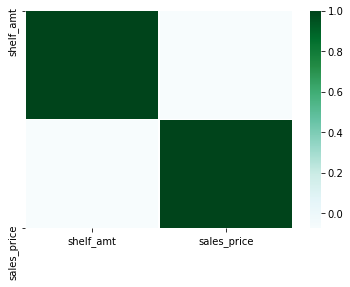

In [12]:
# numerical correlation
num_corr = co_combine[['shelf_amt','sales_price']].corr(method ='pearson')
sns.heatmap(num_corr, cmap="BuGn", linewidths=0.5)

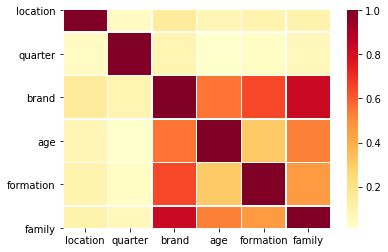

In [13]:
# categorical list without specs
tmp_1 = ['location','quarter','brand','age','formation','family']
# correlation of the categorical features 
df_1 = co_combine[tmp_1]
chi_square = pd.DataFrame(abs(np.random.randn(len(tmp_1),len(tmp_1))), columns= tmp_1, index = tmp_1)

# cramer V statistics for correlation between categorical features
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# chi square dataframe of categorical features
for i in tmp_1:
    temp_list = [k for k in tmp_1 if k!=i]
    for j in temp_list:
        confusion_matrix = pd.crosstab(df_1[i],df_1[j])
        val = cramers_corrected_stat(confusion_matrix)
        chi_square[i][j] = float(val) # column, row
        chi_square[i][i] = 1
        
# heatmap of categorical features (exclude the complex string)
sns.heatmap(chi_square, cmap='YlOrRd', linewidths=0.5)

## 1.5. Glance at columns
### 1.5.1 Numerical data

In [14]:
# plot histogram with accumulative curve
def plot_hist_cum(df, column_name, title, right_range, hist_color, logscale):
    fig, ax1 = plt.subplots()
    ax1.hist(df[column_name].values, range(0,right_range), color = hist_color, 
             alpha = 0.7,density =False, log=logscale)
    ax1.tick_params(labelcolor=hist_color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.hist(df[column_name].values, range(0,right_range), histtype='step', color = 'grey', density = True, 
         cumulative = 1, lw = 2)
    ax2.tick_params(labelcolor='grey')
    plt.title(title)
    plt.show()

In [15]:
co_combine[['sales_amt','shelf_amt','sales_price']].describe(percentiles = [.25, .5, .75, .95])

,sales_amt,shelf_amt,sales_price
count,6942.000000,6.942000e+03,6942.000000
mean,6281.764477,1.022155e+05,88.376693
std,23467.389865,3.478001e+05,49.898150
min,0.000000,0.000000e+00,13.000000
25%,14.000000,1.705000e+02,53.000000
50%,247.000000,3.794500e+03,77.000000
75%,2714.250000,4.453200e+04,111.000000
95%,28323.800000,4.943733e+05,175.000000
max,394983.000000,5.513126e+06,306.000000


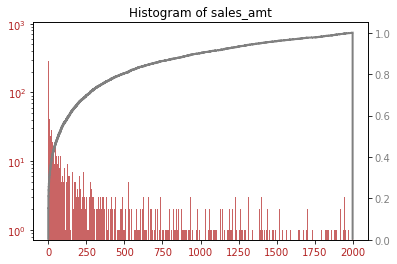

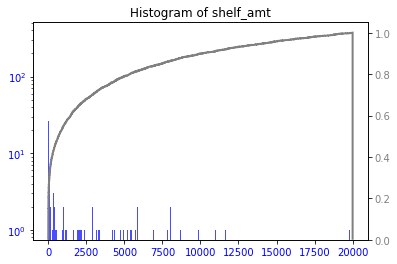

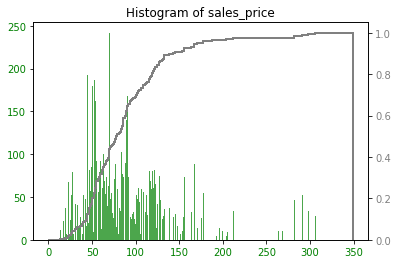

In [16]:
plot_hist_cum(co_combine, 'sales_amt', 'Histogram of sales_amt',2000,'firebrick', True)
plot_hist_cum(co_combine, 'shelf_amt', 'Histogram of shelf_amt',20000,'blue', True)
plot_hist_cum(co_combine, 'sales_price', 'Histogram of sales_price',350,'green', False)

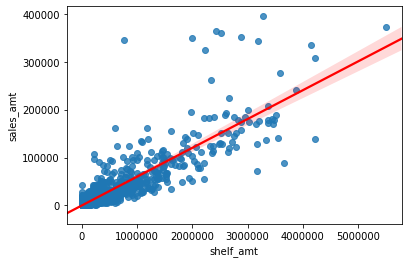

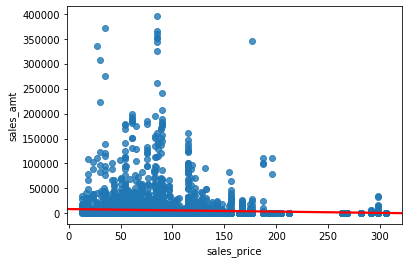

In [17]:
# plot linear dependency between the numberical and target 
for i in ['shelf_amt','sales_price']:
    sns.regplot(i,'sales_amt', data=co_combine,
               line_kws = {'color':'red'}, label = i)
    plt.show()

### 1.5.2 Categorical data
* count of each category
* correlation between categorical feature with sales

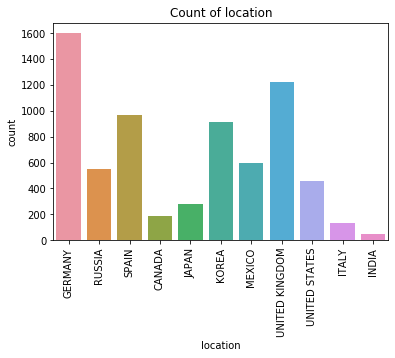

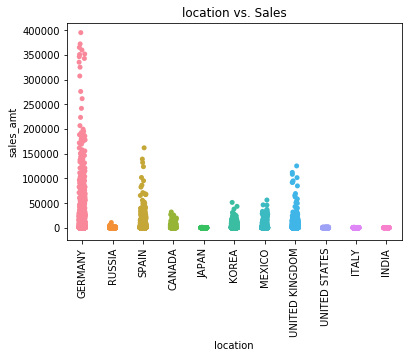

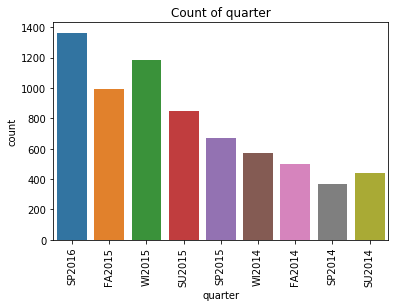

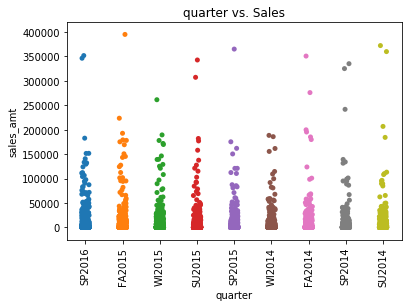

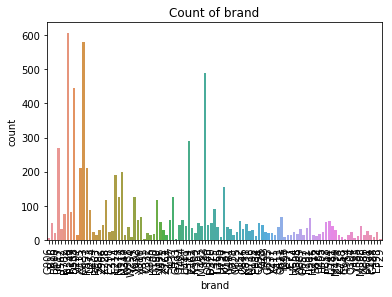

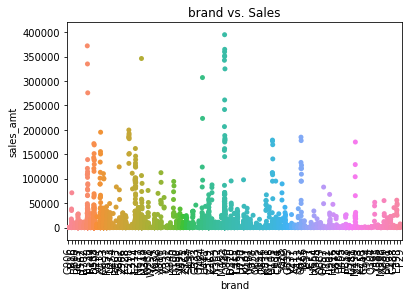

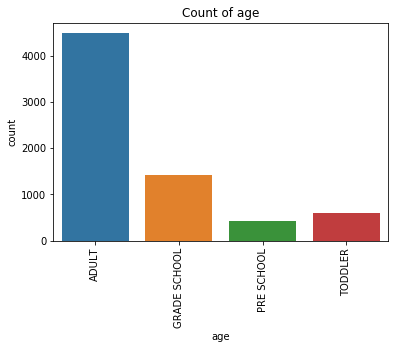

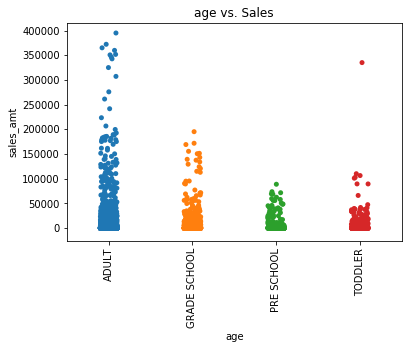

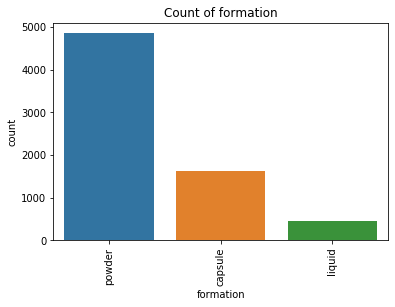

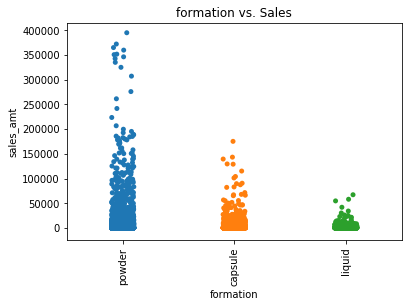

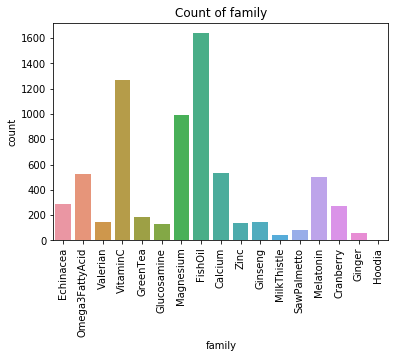

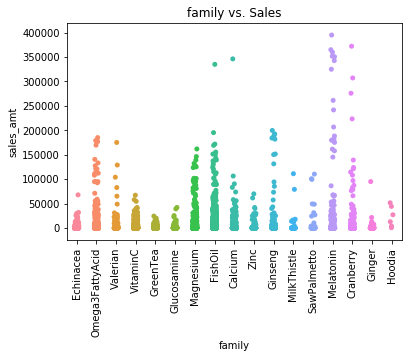

In [18]:
for i in ['location','quarter','brand','age','formation','family']:
    sns.countplot(x=i, data=co_combine)
    plt.xticks(rotation=90)
    plt.title('Count of {}'.format(i))
    plt.show()
    sns.stripplot(x=i, y='sales_amt', data=co_combine, jitter=True)
    plt.xticks(rotation=90)
    plt.title('{} vs. Sales'.format(i))
    plt.show()


# 2. Feature processing
## 2.1 Extra features
* Extra Season and Year out of quarter
* Count # patents in a product

In [19]:
# extract season
co_combine_1 = co_combine.copy(deep =True)
co_combine_1['season'] = co_combine_1['quarter'].astype(str).str[0:2]
co_combine_1['year'] = co_combine_1['quarter'].astype(str).str[2:7]
# co_combine_1.drop(['quarter'], axis =1, inplace=True)
# get numnber of technology, color_family, design_code of each product
num_specs = co_combine_1['specs'].str.split('|').str.len()
co_combine_1['num_specs'] = num_specs


# treat 'specs' in new products as well
new_product_1 = new_product.copy(deep =True)
num_specs_new = new_product_1['specs'].str.split('|').str.len()
new_product_1['num_specs'] = num_specs_new

## 2.2 Bucktize and scaling
* bucktize *sales_price*
* scale numerical features

In [20]:
# bin MSRP_Amt and convert into dummies
price = [1,30,60,80,100,180,450]
price_range = ['<=$30','$30-60','$60-80','$80-100','$100-180','>$180']
price_bin = pd.cut(co_combine_1['sales_price'], price, labels=price_range)
price_seg = pd.get_dummies(price_bin).astype(np.int64)

# carry-over
co_combine_1.drop(['sales_price'], axis =1, inplace=True)
co_combine_1 = pd.concat([co_combine_1, price_seg], axis=1)

# new
price_bin_new = pd.cut(new_product_1['sales_price'], price, labels=price_range)
price_seg_new = pd.get_dummies(price_bin_new).astype(np.int64)
new_product_1.drop(['sales_price'], axis =1, inplace=True)
new_product_1 = pd.concat([new_product_1, price_seg_new], axis=1)

In [21]:
# robust scaling
co_combine_2 = co_combine_1.copy(deep=True)
scale_lst = ['shelf_amt','num_specs']
rs_scale = preprocessing.RobustScaler().fit(co_combine_2[scale_lst])
co_combine_2[scale_lst] = rs_scale.transform(co_combine_2[scale_lst])

# 3. Modeling
* Two models will be developed: one for carry-over products; one for new products
* The carry over model will be training on only its own historical data
* The new model will be training on the data based on similarity with the new products

## 3.1. Carry-over product model
* Use data of each product to build numerous models is not ideal, the average data point of each product/sku is 22, it is too little to build a good model
* Traditional method such as ARIMA could be used, but it lacks the 'insight' of products inner corrleation
* Build a complicated model using more products is a better option
* Target metric y = *sales_amt*
* SP2016 data is used to evaluate the model

### 3.1.1 Dummy features and train/test split

In [22]:
cate_list = ['location','brand','age','formation','family','specs',
             'season','year']
co_combine_2 = pd.get_dummies(co_combine_2,columns=cate_list,drop_first=True) 

In [23]:
# select ~20% latest data for test purpose
co_combine_2_test = co_combine_2[co_combine_2['quarter'] =='SP2016']
co_combine_2_train = co_combine_2[co_combine_2['quarter'] !='SP2016']

In [24]:
# prepare training and test data
co_combine_2_train = shuffle(co_combine_2_train)
co_combine_2_train_X = co_combine_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_train_y = co_combine_2_train['sales_amt'] 

co_combine_2_test_X = co_combine_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_2_test_y = co_combine_2_test['sales_amt'] 

### 3.1.2  Quick linear model for baseline
* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

//miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383157759.4515381, tolerance: 321756423.45932674
  positive)


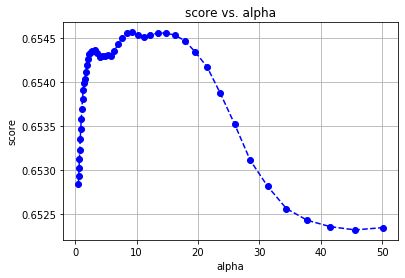

The optimaized alpha and score of Lasso linear is:  9.232219520747307 0.6545664092620482


In [25]:
# Lasso model
alphas = np.logspace (-0.3, 1.7, num=50)
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(co_combine_2_train_X, co_combine_2_train_y)
    scores[i] = lasso.score(co_combine_2_test_X, co_combine_2_test_y)
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [0]:
# use  optimal alpha, re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(co_combine_2_train_X, co_combine_2_train_y)
lasso_pred = lasso_f.predict(co_combine_2_test_X)

In [0]:
co_combine_2_test.head(2)

,sku,quarter,shelf_amt,sales_amt,num_specs,<=$30,$30-60,$60-80,$80-100,$100-180,...,specs_PATENT 8895|PATENT 4533|PATENT 8998|PATENT 2461,specs_PATENT 8924|PATENT 2876,specs_PATENT 9404,specs_PATENT 9404|PATENT 4533,specs_PATENT 9545,season_SP,season_SU,season_WI,year_2015,year_2016
0,12,SP2016,-0.085220,0,-0.5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,12,SP2016,-0.084048,11,-0.5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [0]:
# compare the aggreated prediction with actual sales
co_test_lasso = co_combine_2_test.copy(deep=True)
co_test_lasso['pred'] = np.round(lasso_pred)
co_test_lasso['pred'] = co_test_lasso['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_lasso_agg = co_test_lasso.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

In [0]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_deviation_ratio(y_true, y_pred):
    return y_pred.mad()/(y_true.mad()+0.1)

def evaluate(result_agg):
    MAPE = mean_absolute_percentage_error(result_agg['sales_amt'],result_agg['pred'])
    print 'MAPE of prediction in SP2016 is {}'.format(MAPE)  #MAPE
    MAE = mean_absolute_error(result_agg['sales_amt'], result_agg['pred'])
    print 'MAE of prediction in SP2016 is {}'.format(MAE)   # MAE
    MAD_ratio = mean_absolute_deviation_ratio(result_agg['sales_amt'],result_agg['pred'])
    print 'MAD ratio of prediction in SP2016 is {}'.format(MAD_ratio)
    # MAD ratio
    
def plot_diff(result_agg, title1, title2):    # plot the pred vs. actual
    plt.plot(result_agg['pred'],'o', color='red', alpha=0.3)
    plt.plot(result_agg['sales_amt'],'*', color='blue', alpha=0.5)
    plt.title(title1)
    plt.legend(loc='upper right')
    plt.show()

    plt.plot((result_agg['pred'] - result_agg['sales_amt'])
             ,'v', color='green')
    plt.title(title2)
    plt.show()

In [0]:
evaluate(co_test_lasso_agg)

MAPE of prediction in SP2016 is 1537.60257519
MAE of prediction in SP2016 is 10404.3134796
MAD ratio of prediction in SP2016 is 1.02210171633


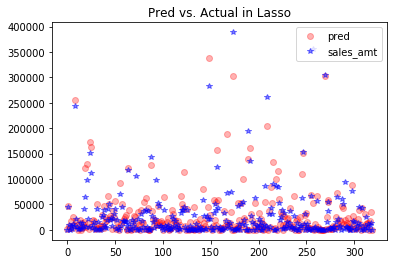

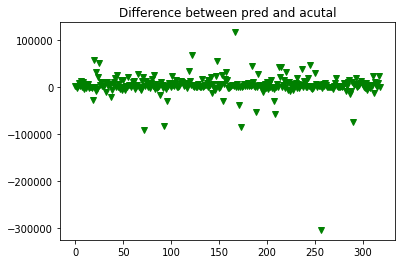

In [0]:
plot_diff(co_test_lasso_agg, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

### 3.1.3 Random forest model

In [0]:
# plot the hyper-parameter tuning
def class_plot(grid, grid_param, title):
    scores = [x for x in grid.cv_results_['mean_test_score']]
    m_depth = grid_param['max_depth']
    n_est = grid_param['n_estimators']
    scores = np.array(scores).reshape(len(m_depth), len(n_est))
    fig = plt.figure()
    ax = plt.subplot(111)
    for ind, i in enumerate(m_depth):
        plt.plot(n_est, scores[ind], '-o', label='Max depth' + str(i),)
    ax.legend(loc='lower right') #, bbox_to_anchor=(1, 0.5))
    plt.xlabel('n estimator')
    plt.ylabel('Mean score')
    plt.title(title)
    plt.show()
    

# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

In [0]:
grid_1 = {'n_estimators': [5,10,15,20,30,40,50],
          'max_depth': [30,40,45,50,55,60,70]}

rf_1 = RandomForestRegressor(random_state=2019, verbose=1,n_jobs =6)
grid_rf_1 = GridSearchCV(rf_1, grid_1, cv=3)
grid_rf_1.fit(co_combine_2_train_X, co_combine_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    6.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   9 out of  20 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Para

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend Thre

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=6,
           oob_score=False, random_state=2019, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 30, 40, 50], 'max_depth': [30, 40, 45, 50, 55, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

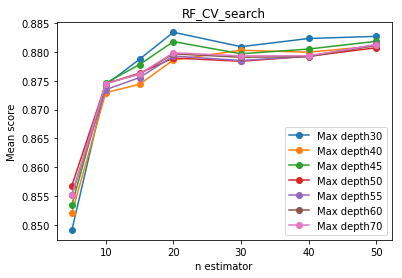

In [0]:
class_plot(grid_rf_1, grid_1, 'RF_CV_search')

In [0]:
print grid_rf_1.best_params_
print grid_rf_1.best_score_

{'n_estimators': 20, 'max_depth': 30}
0.8834138377995384


In [0]:
# re-train the model with full training set
rf_best = grid_rf_1.best_estimator_
rf_best.fit(co_combine_2_train_X, co_combine_2_train_y)
pred_rf_test = rf_best.predict(co_combine_2_test_X)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.0s finished


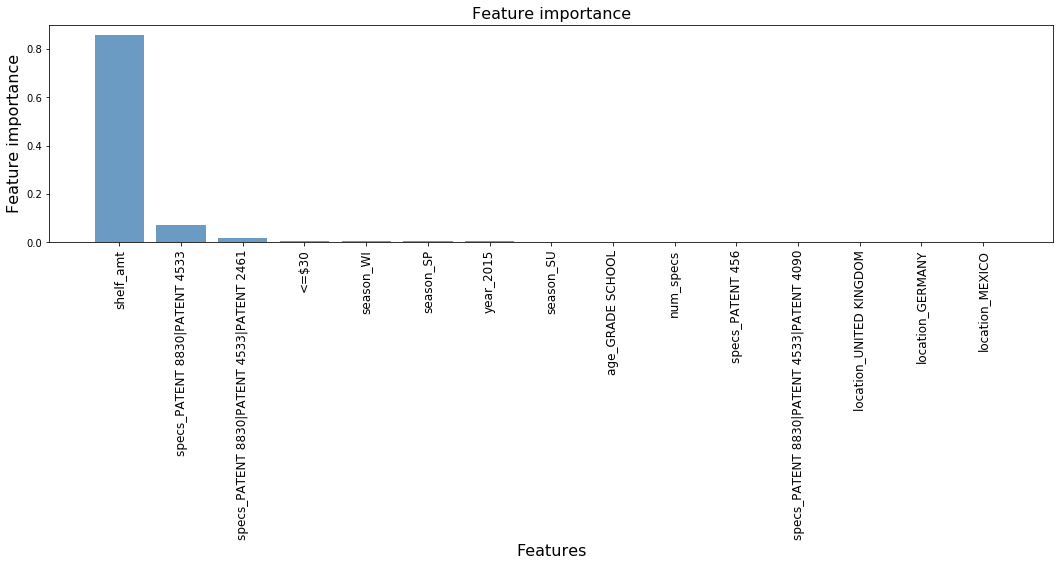

In [0]:
importance_rf_best = rf_best.feature_importances_
names_rf_best = co_combine_2_train_X.columns.tolist()
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})
# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 18, 4, 'Feature importance')

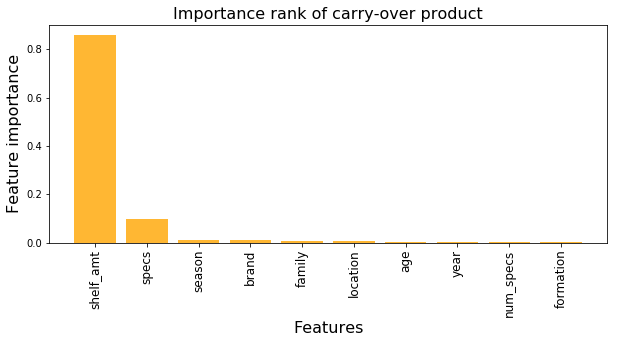

In [0]:
# plot feature importance ranking of original feature (before dummies)
raw_feature_importances_rf_best = raw_feature_importance(df_importantce_rf_best,2,cate_list)

plot_feature_importance(raw_feature_importances_rf_best, 21, 'orange', 0.8, 10, 4, 
                        'Importance rank of carry-over product')

In [0]:
# compare the aggreated prediction with actual sales
co_test_rf = co_combine_2_test.copy(deep=True)
co_test_rf['pred'] = np.round(pred_rf_test)
co_test_rf['pred'] = co_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
co_test_rf_agg = co_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

In [0]:
evaluate(co_test_rf_agg)

MAPE of prediction in SP2016 is 94.8393491506
MAE of prediction in SP2016 is 8538.34796238
MAD ratio of prediction in SP2016 is 0.965502512095


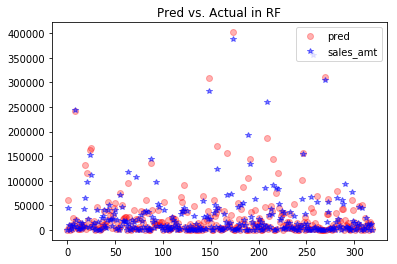

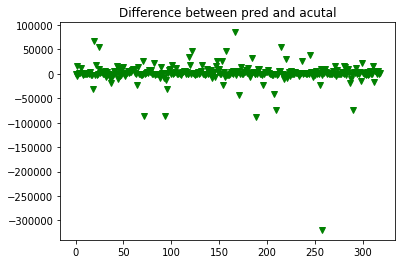

In [0]:
plot_diff(co_test_rf_agg, 'Pred vs. Actual in RF', 'Difference between pred and acutal')

In [0]:
# re-train with training+test data, save model for future prediction
co_combine_3 = co_combine_2.copy(deep =True)
co_combine_3 = shuffle(co_combine_3)
co_combine_3_X = co_combine_3.drop(['sku','quarter','sales_amt'],axis = 1)
co_combine_3_y = co_combine_3['sales_amt'] 

rf_best.fit(co_combine_3_X,co_combine_3_y)

# save model
joblib.dump(rf_best, 'rf_best_co.sav', compress=3)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    0.4s finished


['rf_best_co.sav']

## 3.2 New product model
* The product is new and has not been sold before.
* Find a group of old products similiar to the new product, train a model on them, and use this model for prediction
* Clustering could be another method, number of clusters can be a hyper-parameter

### 3.2.1 Similar product search¶
* Analyze the cosine similarity bewteen 87 new products in *new_product_1* and 320 products in *co_combine_1* with full historical data
* For each new product, the top 3 most similar old products are chosen
* Then use the data of these chosen carry-over products to train a model, which can predict demand of new products

In [0]:
similarity_prod = co_combine_1[['sku','brand','age','formation','family',
                                'specs','num_specs','<=$30','$30-60',
                                '$60-80','$80-100','$100-180','>$180']]

cate_similarity = ['brand','age','formation','family','specs']
                   
similarity_prod_dummy = pd.get_dummies(similarity_prod,columns=cate_similarity,
                                       drop_first=True) 

# get unique rows for cosine similarity compare
similarity_prod_dummy.drop_duplicates(inplace = True)

# this is is later ID mapping
prod_ID = similarity_prod_dummy['sku']

s_list = similarity_prod_dummy.drop(['sku'],axis=1).values.tolist()
# to operate cosine similarity



In [0]:
new_prod_dummy = pd.get_dummies(new_product_1,columns=cate_similarity,
                                       drop_first=True) 

In [0]:
# make the same column in whole data and new product data
diff_sim = list((set(new_prod_dummy.columns) -set(similarity_prod_dummy.columns)))
if len(diff_sim)!=0:
    new_prod_dummy.drop(diff_sim, axis = 1, inplace =True)

missing_cols_sim = set(similarity_prod_dummy.columns) - set(new_prod_dummy.columns)
# Add a missing column in test set with default value equal to 0
for m in missing_cols_sim:
    new_prod_dummy[m] = 0
    
new_prod_dummy = new_prod_dummy[similarity_prod_dummy.columns]

# get unique rows for cosine similarity compare
new_prod_dummy.drop_duplicates(inplace = True)
new_prod_ID = new_prod_dummy['sku']

s_new = new_prod_dummy.drop(['sku'], axis=1)
s_new_list = s_new.values.tolist()

In [0]:
# a special dict to have list as key, to keep order
# get the similarity between 87 new products and 320 carry-over products
d_sim = defaultdict(list)

for i in range(len(new_prod_ID)):
    for j in range(len(prod_ID)):
        s_new_list[i] = np.array(s_new_list[i]).reshape(1,-1)
        s_list[j] = np.array(s_list[j]).reshape(1,-1)
        tmp_sim = float(cosine_similarity(s_new_list[i],s_list[j]))
        d_sim[i].append(tmp_sim)

In [0]:
len(d_sim)

87

In [0]:
# get the top 3 most similar products list with each new product
high_sim_prod_index = set()
for ID in range(87):
    tmp_3 = sorted(range(320), key=lambda i: d_sim[ID][i])[-3:]
    for p in tmp_3:
        high_sim_prod_index.add(p)
        
high_sim_prod_ID = prod_ID.iloc[list(high_sim_prod_index)]
# high_sim_prod_ID.tolist()

### 3.2.2 Training/testing data for new product

In [0]:
similar_new_1 = co_combine_1[co_combine_1['sku'].isin(high_sim_prod_ID)]
print similar_new_1.shape
similar_new_2 = pd.get_dummies(similar_new_1,columns=cate_list,drop_first=True) 

(4141, 19)


In [0]:
# select ~20% latest data for test purpose
similar_new_2_test = similar_new_2[similar_new_2['quarter'] =='SP2016']
similar_new_2_train = similar_new_2[similar_new_2['quarter'] !='SP2016']

# prepare training and test data
similar_new_2_train = shuffle(similar_new_2_train)
similar_new_2_train_X = similar_new_2_train.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_train_y = similar_new_2_train['sales_amt'] 

similar_new_2_test_X = similar_new_2_test.drop(['sku','quarter','sales_amt'],axis = 1)
similar_new_2_test_y = similar_new_2_test['sales_amt'] 

### 3.2.3 Random forest model

In [0]:
grid_2 = {'n_estimators': [15,20,30,40,50,60,70,80],
          'max_depth': [5,10,20,30,40,50]}

rf_2 = RandomForestRegressor(random_state=2019, verbose=1,n_jobs =6)
grid_rf_2 = GridSearchCV(rf_2, grid_2, cv=3)
grid_rf_2.fit(similar_new_2_train_X, similar_new_2_train_y)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent worker

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  40 out 

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=6,
           oob_score=False, random_state=2019, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [15, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

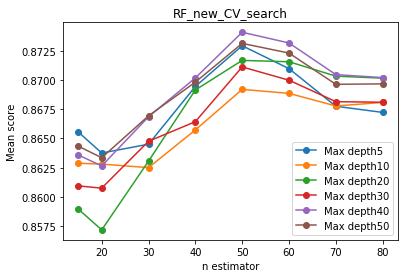

{'n_estimators': 50, 'max_depth': 40}
0.8740823235216577


In [0]:
class_plot(grid_rf_2, grid_2, 'RF_new_CV_search')
print grid_rf_2.best_params_
print grid_rf_2.best_score_

In [0]:
# re-train the model with full training set
rf_best_new = grid_rf_2.best_estimator_
rf_best_new.fit(similar_new_2_train_X, similar_new_2_train_y)
# save model
joblib.dump(rf_best_new, 'rf_best_new.sav', compress=3)

pred_rf_test_new = rf_best_new.predict(similar_new_2_test_X)

# compare the aggreated prediction with actual sales
new_test_rf = similar_new_2_test.copy(deep=True)
new_test_rf['pred'] = np.round(pred_rf_test_new)
new_test_rf['pred'] = new_test_rf['pred'].clip(lower=0)

function_2 = {'sales_amt':'sum', 'pred':'sum'}
new_test_rf_agg = new_test_rf.groupby(['sku','quarter'],
                                    as_index = False).agg(function_2)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


In [0]:
evaluate(new_test_rf_agg)

MAPE of prediction in SP2016 is 84.239533378
MAE of prediction in SP2016 is 10030.2971429
MAD ratio of prediction in SP2016 is 0.936399625086


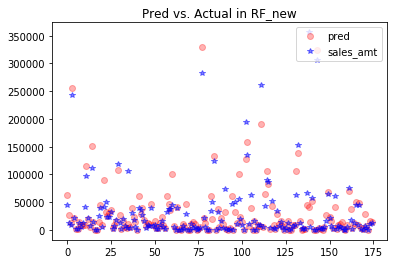

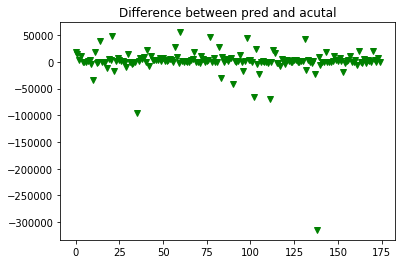

In [0]:
plot_diff(new_test_rf_agg, 'Pred vs. Actual in RF_new', 'Difference between pred and acutal')

# 4.Prediction
* Use carry-over model and new-product model for carry-over and new products respectively
* Pre-process the input data so that they have the same columns as the data used to train the model
